In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [22]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([0/255, 0/255, 0/255, 0.9])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
    

In [23]:
image = cv2.imread('frame0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

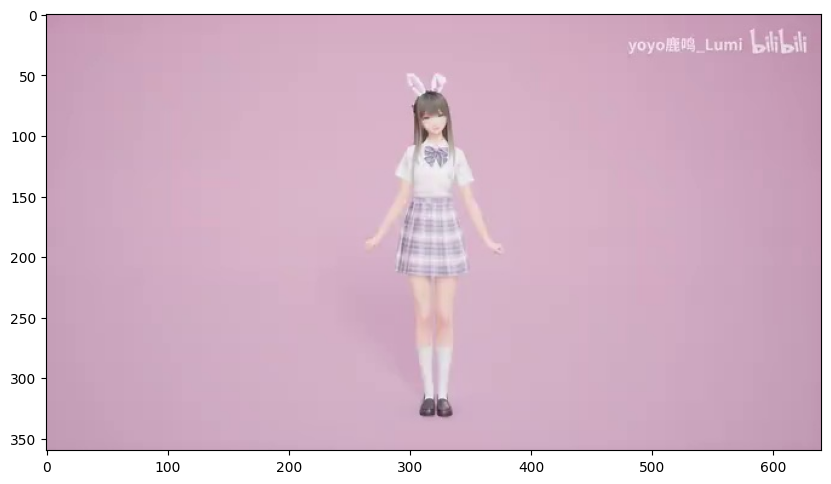

In [24]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [25]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam_model=sam)

predictor.set_image(image)

In [26]:
input_point = np.array([[310, 150]])
input_label = np.array([1])

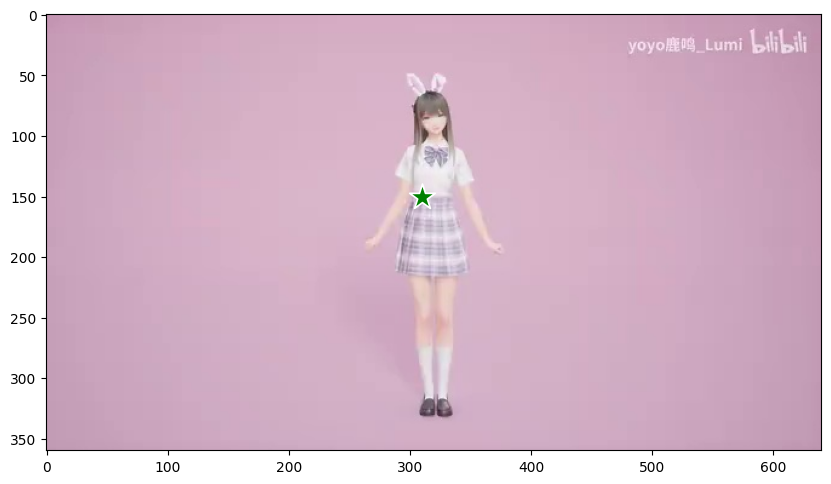

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [28]:
masks, scroes, logits = predictor.predict(
    point_coords=input_point, 
    point_labels=input_label,
    multimask_output=True,
)

In [29]:
masks.shape

(3, 360, 640)

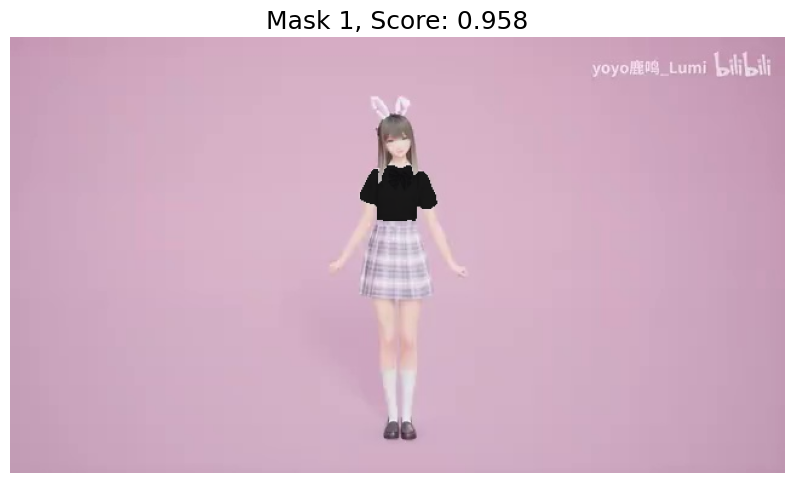

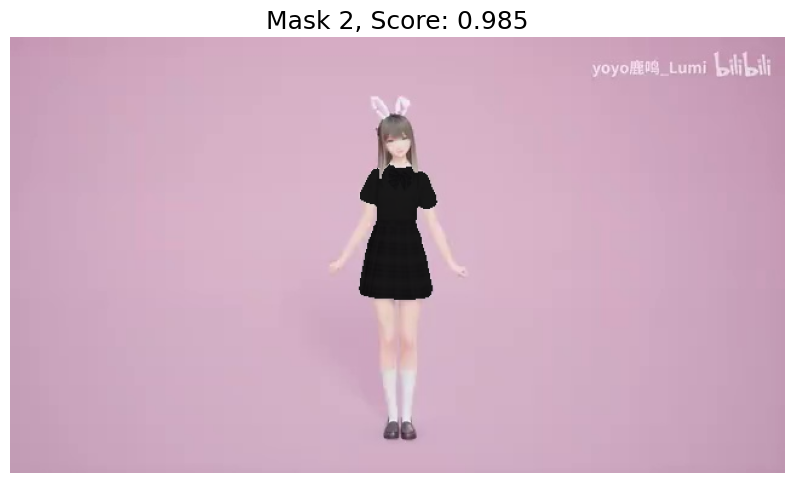

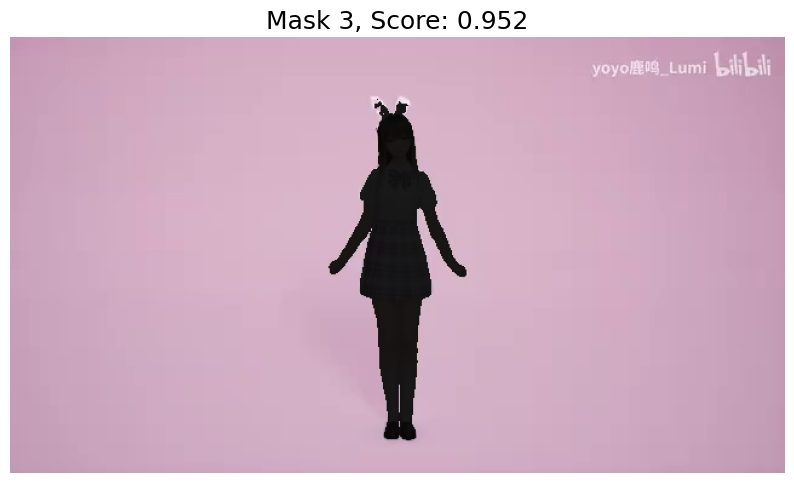

In [30]:
for i, (mask, score) in enumerate(zip(masks, scroes)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    #show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [10]:
np.argmin(scroes)

2

In [31]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

In [32]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)
masks.shape

torch.Size([4, 1, 1200, 1800])

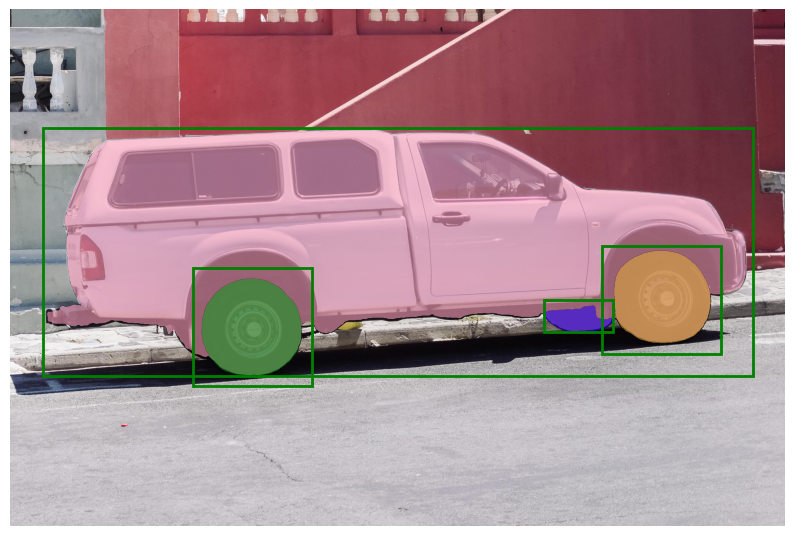

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()